In [2]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.layers import Input, BatchNormalization, Dropout, Lambda
from tqdm import tqdm_notebook

In [3]:
train=np.zeros(140)
train_df=pd.DataFrame(train)

In [4]:
train_df.columns=(["index"])
for i in range(0,len(train_df)):
    train_df.iloc[i,0]=int(i)

In [3]:
from tqdm import tqdm
add=os.listdir("I:\\小組雲端硬碟\\影像辨識專題-自己小組\\圖片檔\\seg_要用的\\original\\");
add_='I:\\小組雲端硬碟\\影像辨識專題-自己小組\\圖片檔\\seg_要用的\\original\\'
maskadd=os.listdir("I:\\小組雲端硬碟\\影像辨識專題-自己小組\\圖片檔\\seg_要用的\\mask\\");
path1='I:\\小組雲端硬碟\\影像辨識專題-自己小組\\圖片檔\\seg_要用的\\mask\\'

In [6]:
train_df["address"]=None
for j in range(0,len(train_df)):
    train_df.iloc[j,1]=os.path.join(add_+add[j])



In [5]:
len(add)

248

In [8]:
for j in range(0,len(train_df)):
    train_df.iloc[j,2]=os.path.join(path1+add[j])

In [6]:
im_height=im_width=256
im_chan=3
X_train = np.zeros((len(add), im_height, im_width, im_chan), dtype=np.float)
Y_train = np.zeros((len(add), im_height, im_width, 1), dtype=np.bool)

In [7]:
for n, id_ in tqdm(enumerate(add), total=len(add)):
    path = add_
    img = load_img(path  + id_)
    x = img_to_array(img)[:,:,:im_chan]
    x = resize(x, (256, 256,3), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path1  + id_))[:,:,1]
    Y_train[n] = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)

print('Done!')

  0%|                                                                                          | 0/248 [00:00<?, ?it/s]C:\Users\HP\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:12<00:00, 26.25it/s]


Done!


In [58]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [240]:
inputs = Input((im_height, im_width, im_chan))
#s = Lambda(lambda x: x/255 ) (inputs)
s = BatchNormalization()(inputs)
s = Dropout(0.5)(s)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.001), loss=bce_dice_loss, metrics=['accuracy'])

In [20]:
#new
inputs = Input((im_height, im_width, im_chan))
#s = Lambda(lambda x: x/255 ) (inputs)
s = BatchNormalization()(inputs)
s = Dropout(0.5)(s)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p5)
c6 = Dropout(0.3) (c6)
c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c5])
c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.2) (c9)
c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c2])
c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c10)

u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u11)
c11 = Dropout(0.1) (c11)
c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c11)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.0001), loss=bce_dice_loss, metrics=['mse'])

In [9]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



In [21]:
earlystopper = EarlyStopping(patience=5)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', save_best_only=True)

In [22]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=8, epochs=100, 
                    
                    callbacks=[earlystopper, checkpointer],
                     verbose=1
                   )

Train on 198 samples, validate on 50 samples
Epoch 1/100
198/198 [==============================] - ETA: 4:58 - loss: 2.0474 - mean_squared_error: 0.47 - ETA: 3:56 - loss: 1.9430 - mean_squared_error: 0.45 - ETA: 3:34 - loss: 1.9203 - mean_squared_error: 0.43 - ETA: 3:16 - loss: 1.8655 - mean_squared_error: 0.42 - ETA: 3:00 - loss: 1.8454 - mean_squared_error: 0.41 - ETA: 2:48 - loss: 1.8290 - mean_squared_error: 0.41 - ETA: 2:37 - loss: 1.8041 - mean_squared_error: 0.40 - ETA: 2:28 - loss: 1.7928 - mean_squared_error: 0.39 - ETA: 2:19 - loss: 1.7754 - mean_squared_error: 0.38 - ETA: 2:10 - loss: 1.7553 - mean_squared_error: 0.38 - ETA: 2:00 - loss: 1.7320 - mean_squared_error: 0.37 - ETA: 1:51 - loss: 1.7118 - mean_squared_error: 0.37 - ETA: 1:42 - loss: 1.7005 - mean_squared_error: 0.36 - ETA: 1:33 - loss: 1.6838 - mean_squared_error: 0.36 - ETA: 1:24 - loss: 1.6680 - mean_squared_error: 0.35 - ETA: 1:15 - loss: 1.6560 - mean_squared_error: 0.35 - ETA: 1:06 - loss: 1.6440 - mean_squa

198/198 [==============================] - ETA: 3:17 - loss: 1.3208 - mean_squared_error: 0.19 - ETA: 3:05 - loss: 1.3220 - mean_squared_error: 0.19 - ETA: 2:55 - loss: 1.3279 - mean_squared_error: 0.19 - ETA: 2:47 - loss: 1.3244 - mean_squared_error: 0.20 - ETA: 2:38 - loss: 1.3310 - mean_squared_error: 0.20 - ETA: 2:30 - loss: 1.3333 - mean_squared_error: 0.20 - ETA: 2:22 - loss: 1.3339 - mean_squared_error: 0.20 - ETA: 2:14 - loss: 1.3369 - mean_squared_error: 0.20 - ETA: 2:06 - loss: 1.3390 - mean_squared_error: 0.20 - ETA: 1:58 - loss: 1.3382 - mean_squared_error: 0.20 - ETA: 1:50 - loss: 1.3366 - mean_squared_error: 0.20 - ETA: 1:42 - loss: 1.3368 - mean_squared_error: 0.20 - ETA: 1:34 - loss: 1.3387 - mean_squared_error: 0.20 - ETA: 1:26 - loss: 1.3381 - mean_squared_error: 0.20 - ETA: 1:18 - loss: 1.3374 - mean_squared_error: 0.20 - ETA: 1:11 - loss: 1.3362 - mean_squared_error: 0.20 - ETA: 1:03 - loss: 1.3365 - mean_squared_error: 0.20 - ETA: 55s - loss: 1.3360 - mean_squared_

198/198 [==============================] - ETA: 3:26 - loss: 1.0084 - mean_squared_error: 0.13 - ETA: 3:31 - loss: 1.0948 - mean_squared_error: 0.14 - ETA: 3:12 - loss: 1.0878 - mean_squared_error: 0.14 - ETA: 2:58 - loss: 1.1140 - mean_squared_error: 0.15 - ETA: 2:47 - loss: 1.0980 - mean_squared_error: 0.14 - ETA: 2:37 - loss: 1.0929 - mean_squared_error: 0.14 - ETA: 2:27 - loss: 1.0989 - mean_squared_error: 0.14 - ETA: 2:20 - loss: 1.0865 - mean_squared_error: 0.14 - ETA: 2:14 - loss: 1.0872 - mean_squared_error: 0.15 - ETA: 2:04 - loss: 1.0908 - mean_squared_error: 0.15 - ETA: 1:56 - loss: 1.0984 - mean_squared_error: 0.15 - ETA: 1:47 - loss: 1.0884 - mean_squared_error: 0.15 - ETA: 1:39 - loss: 1.0883 - mean_squared_error: 0.15 - ETA: 1:30 - loss: 1.0992 - mean_squared_error: 0.15 - ETA: 1:22 - loss: 1.1046 - mean_squared_error: 0.15 - ETA: 1:13 - loss: 1.1051 - mean_squared_error: 0.15 - ETA: 1:04 - loss: 1.1066 - mean_squared_error: 0.15 - ETA: 56s - loss: 1.1043 - mean_squared_

198/198 [==============================] - ETA: 3:31 - loss: 1.1091 - mean_squared_error: 0.16 - ETA: 3:35 - loss: 1.0740 - mean_squared_error: 0.16 - ETA: 3:16 - loss: 1.1015 - mean_squared_error: 0.16 - ETA: 3:02 - loss: 1.0699 - mean_squared_error: 0.16 - ETA: 2:53 - loss: 1.0605 - mean_squared_error: 0.15 - ETA: 2:48 - loss: 1.0464 - mean_squared_error: 0.15 - ETA: 2:37 - loss: 1.0426 - mean_squared_error: 0.15 - ETA: 2:26 - loss: 1.0389 - mean_squared_error: 0.15 - ETA: 2:16 - loss: 1.0359 - mean_squared_error: 0.14 - ETA: 2:07 - loss: 1.0280 - mean_squared_error: 0.14 - ETA: 1:58 - loss: 1.0296 - mean_squared_error: 0.14 - ETA: 1:49 - loss: 1.0317 - mean_squared_error: 0.14 - ETA: 1:42 - loss: 1.0361 - mean_squared_error: 0.14 - ETA: 1:32 - loss: 1.0427 - mean_squared_error: 0.14 - ETA: 1:23 - loss: 1.0499 - mean_squared_error: 0.14 - ETA: 1:15 - loss: 1.0376 - mean_squared_error: 0.14 - ETA: 1:06 - loss: 1.0450 - mean_squared_error: 0.14 - ETA: 58s - loss: 1.0514 - mean_squared_

198/198 [==============================] - ETA: 2:51 - loss: 1.0030 - mean_squared_error: 0.13 - ETA: 2:49 - loss: 1.0916 - mean_squared_error: 0.15 - ETA: 2:40 - loss: 1.0376 - mean_squared_error: 0.14 - ETA: 2:32 - loss: 1.0404 - mean_squared_error: 0.14 - ETA: 2:25 - loss: 1.0373 - mean_squared_error: 0.14 - ETA: 2:17 - loss: 1.0408 - mean_squared_error: 0.15 - ETA: 2:10 - loss: 1.0365 - mean_squared_error: 0.15 - ETA: 2:02 - loss: 1.0445 - mean_squared_error: 0.15 - ETA: 1:55 - loss: 1.0417 - mean_squared_error: 0.15 - ETA: 1:48 - loss: 1.0496 - mean_squared_error: 0.15 - ETA: 1:41 - loss: 1.0424 - mean_squared_error: 0.15 - ETA: 1:34 - loss: 1.0576 - mean_squared_error: 0.15 - ETA: 1:28 - loss: 1.0594 - mean_squared_error: 0.15 - ETA: 1:22 - loss: 1.0572 - mean_squared_error: 0.15 - ETA: 1:15 - loss: 1.0572 - mean_squared_error: 0.15 - ETA: 1:07 - loss: 1.0578 - mean_squared_error: 0.15 - ETA: 59s - loss: 1.0569 - mean_squared_error: 0.1503 - ETA: 51s - loss: 1.0539 - mean_squared

198/198 [==============================] - ETA: 3:03 - loss: 1.0513 - mean_squared_error: 0.14 - ETA: 3:01 - loss: 1.0332 - mean_squared_error: 0.13 - ETA: 2:52 - loss: 1.0204 - mean_squared_error: 0.13 - ETA: 2:46 - loss: 1.0438 - mean_squared_error: 0.14 - ETA: 2:42 - loss: 1.0665 - mean_squared_error: 0.14 - ETA: 2:33 - loss: 1.0671 - mean_squared_error: 0.14 - ETA: 2:23 - loss: 1.0574 - mean_squared_error: 0.14 - ETA: 2:14 - loss: 1.0599 - mean_squared_error: 0.14 - ETA: 2:05 - loss: 1.0483 - mean_squared_error: 0.14 - ETA: 1:57 - loss: 1.0414 - mean_squared_error: 0.14 - ETA: 1:49 - loss: 1.0351 - mean_squared_error: 0.14 - ETA: 1:40 - loss: 1.0391 - mean_squared_error: 0.14 - ETA: 1:32 - loss: 1.0443 - mean_squared_error: 0.14 - ETA: 1:24 - loss: 1.0368 - mean_squared_error: 0.14 - ETA: 1:16 - loss: 1.0281 - mean_squared_error: 0.14 - ETA: 1:08 - loss: 1.0224 - mean_squared_error: 0.14 - ETA: 1:00 - loss: 1.0176 - mean_squared_error: 0.14 - ETA: 52s - loss: 1.0217 - mean_squared_

198/198 [==============================] - ETA: 2:55 - loss: 0.9507 - mean_squared_error: 0.13 - ETA: 2:47 - loss: 1.0474 - mean_squared_error: 0.16 - ETA: 2:40 - loss: 1.0062 - mean_squared_error: 0.15 - ETA: 2:32 - loss: 1.0142 - mean_squared_error: 0.15 - ETA: 2:27 - loss: 1.0247 - mean_squared_error: 0.14 - ETA: 2:23 - loss: 1.0063 - mean_squared_error: 0.14 - ETA: 2:16 - loss: 0.9992 - mean_squared_error: 0.13 - ETA: 2:08 - loss: 0.9892 - mean_squared_error: 0.13 - ETA: 2:00 - loss: 0.9815 - mean_squared_error: 0.13 - ETA: 1:52 - loss: 0.9833 - mean_squared_error: 0.13 - ETA: 1:44 - loss: 0.9874 - mean_squared_error: 0.13 - ETA: 1:36 - loss: 0.9962 - mean_squared_error: 0.13 - ETA: 1:29 - loss: 0.9798 - mean_squared_error: 0.13 - ETA: 1:21 - loss: 0.9693 - mean_squared_error: 0.13 - ETA: 1:13 - loss: 0.9724 - mean_squared_error: 0.13 - ETA: 1:06 - loss: 0.9720 - mean_squared_error: 0.13 - ETA: 58s - loss: 0.9805 - mean_squared_error: 0.1388 - ETA: 50s - loss: 0.9807 - mean_squared

In [26]:
preds_train = model.predict(X_train[230:248], verbose=1)


18/18 [==============================] - 5s 258ms/step


In [18]:
from keras.models import Model, load_model
model = load_model('model-tgs-salt-1.h5',custom_objects={'bce_dice_loss': bce_dice_loss})

In [28]:
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_train_t = (preds_train > 0.5).astype(np.uint8)

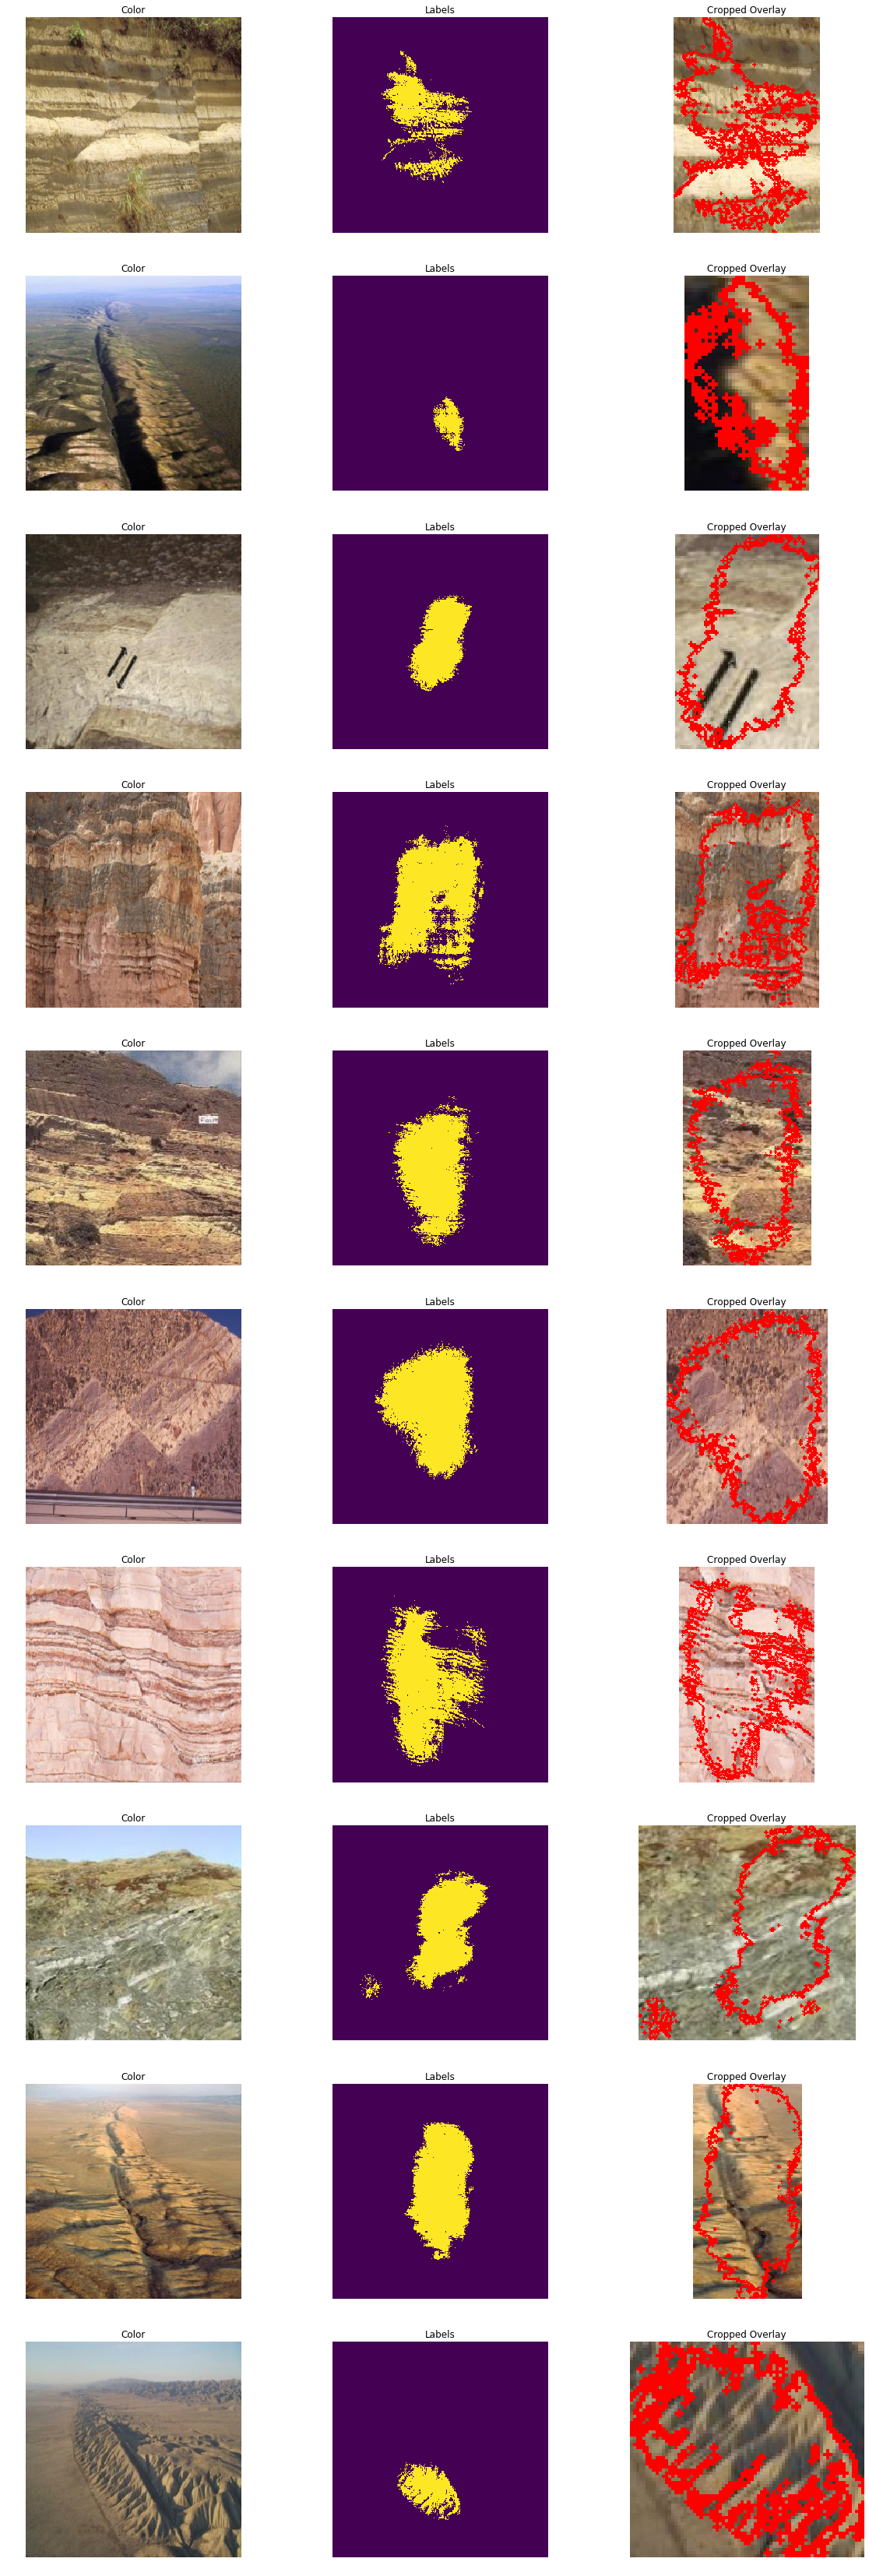

In [31]:
from skimage.segmentation import mark_boundaries
sample_rows = 10
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), rgb_img, lab_img in zip(m_axs,X_train[230:248] ,preds_train_t ):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img[:,:,0], cmap = 'viridis')  #viridis  nipy_spectral
    ax2.set_title('Labels')
    if lab_img.max()>0.1:
        xd, yd = np.where(lab_img[:,:,0]>0)
        bound_img = mark_boundaries(image = r_rgb_img, label_img = lab_img[:,:,0], 
                                    color = (1,0,0), background_label = 255, mode = 'thick')
        ax3.imshow(bound_img[xd.min():xd.max(), yd.min():yd.max(),:])
        ax3.set_title('Cropped Overlay')